In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.svm import SVR, SVC
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from math import radians, cos, sin, asin, sqrt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

In [2]:
train  = pd.read_csv("TrainingData.csv")
test   = pd.read_csv("ValidationData.csv")

In [3]:
train.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(2), int64(527)
memory usage: 80.5 MB


Missing values
No missing values

<AxesSubplot:>

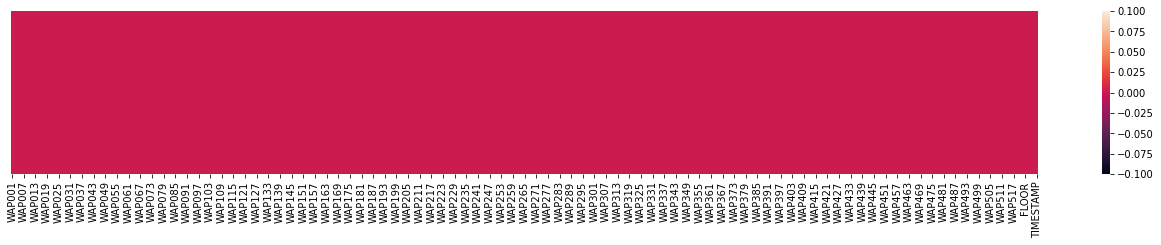

In [5]:
plt.figure(figsize=(23, 3))
sns.heatmap(train.isnull(), yticklabels=False, cbar=True)

Checking the datastyp
No cat type

In [6]:
num_col = train._get_numeric_data().columns.tolist()
cat_col = set(train.columns) - set(num_col)
print(cat_col)

set()


Define the problem
Create single value from Latitude and Longitude
Haversine formula

In [8]:
def haversine(lat, lng):
    r = 6371
    lat, lng = map(radians, [lat, lng])
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    return 2 * r * asin(sqrt(a)) 

In [9]:
dist = []
for i in range(train.shape[0]):
    dist.append(haversine(train.LONGITUDE[i], train.LATITUDE[i]))
dist = pd.Series(dist)
train['distance'] = dist.values
train.distance

0        13069.527499
1        11614.329329
2        10046.891562
3        11442.450644
4         8961.351451
             ...     
19932    11669.808937
19933     2898.463946
19934    14400.743891
19935    15396.940642
19936    15148.704873
Name: distance, Length: 19937, dtype: float64

In [10]:
dist = []
for i in range(test.shape[0]):
    dist.append(haversine(test.LONGITUDE[i], test.LATITUDE[i]))
dist = pd.Series(dist)
test['distance'] = dist.values
test.distance

0       14302.235625
1        2291.753627
2        1623.623059
3        2460.632158
4       10444.215673
            ...     
1106     8737.912127
1107     9040.723582
1108    11013.604430
1109    11053.284178
1110    10975.936959
Name: distance, Length: 1111, dtype: float64

In [11]:
train.columns

Index(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007',
       'WAP008', 'WAP009', 'WAP010',
       ...
       'LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID',
       'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP', 'distance'],
      dtype='object', length=530)

In [12]:
drop_c = ['LONGITUDE', 'LATITUDE', 'FLOOR', 'SPACEID', 'RELATIVEPOSITION', 'BUILDINGID', 'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP']
train_r = train.drop(drop_c, axis=1)
test_r = test.drop(drop_c, axis=1)

In [13]:
#Check the unique values of the features
train_sample = train_r.sample(n=2500)

In [14]:
for i in range(train_sample.shape[1]):
    print("Feature " + str(i) + " Unique values")
    print(np.unique(train_sample.iloc[:, i]))
    print("----------")

Feature 0 Unique values
[-96 -95 -93 100]
----------
Feature 1 Unique values
[-86 100]
----------
Feature 2 Unique values
[100]
----------
Feature 3 Unique values
[100]
----------
Feature 4 Unique values
[-96 -94 -92 -90 100]
----------
Feature 5 Unique values
[-95 -94 -93 -91 -90 -89 -88 -87 -86 -85 -83 -82 -81 -78 -77 -70 -67 100]
----------
Feature 6 Unique values
[-98 -97 -96 -95 -94 -93 -91 -90 -89 -88 -87 -86 -85 -84 -83 -81 -80 -79
 -77 -76 -75 -74 -73 -71 -62 -59 -58 -57 -56 -55 -48 -47 100]
----------
Feature 7 Unique values
[-97 -96 -94 -93 -92 -91 -90 -89 -88 -87 -86 -85 -84 -83 -82 -80 -79 -78
 -75 -74 -72 -70 -69 -68 -67 -66 -63 100]
----------
Feature 8 Unique values
[-97 -95 -93 -92 -90 -89 -88 -87 -86 -85 -84 -83 -81 -80 -79 -78 -77 -76
 -75 -73 -72 -71 -70 -69 -67 -66 -65 -64 -63 -62 -61 -56 -51 100]
----------
Feature 9 Unique values
[-96 -94 -92 -90 100]
----------
Feature 10 Unique values
[-101  -99  -97  -96  -95  -94  -92  -91  -90  -89  -88  -87  -86  -85
  -84  

In [15]:
#sampling
#Due to the high dimension of the dataset, I am analyzing the random sample of the collection

#remove all zero-variance features

dt = np.concatenate((train_r, test_r))
dt = pd.DataFrame(dt)

In [16]:
sel = VarianceThreshold()
dt = sel.fit_transform(dt)
print(dt.shape)

(21048, 521)


In [17]:
#Define dependant and response variables
X = dt[:5000, :-1]
y = dt[:5000, -1]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Modeling
Modeling with regression
This modeling is based on the distance as the response value

In [18]:
reg = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
reg.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

In [19]:
reg.score(x_test, y_test)

0.02838913429274803

Classification
The floor considered as a class label

In [20]:
drop_c = ['LONGITUDE', 'LATITUDE', 'distance', 'RELATIVEPOSITION', 'BUILDINGID','SPACEID','RELATIVEPOSITION', 'USERID', 'USERID', 'TIMESTAMP', 'PHONEID']
train_c = (train.drop(drop_c, axis=1)).values
test_c = (test.drop(drop_c, axis=1)).values

In [21]:
dt = np.concatenate((train_c, test_c))
dt = pd.DataFrame(dt)

sel = VarianceThreshold()

dt = sel.fit_transform(dt)
print(dt.shape)

X_train = train_c[:5000, :-1]
Y_train = train_c[:5000, -1]

X_test = test_c[:, :-1]
Y_test = test_c[:, -1]

(21048, 521)


C-Support Vector Classification
K-Neighbors Classifier
C5.0¶

In [22]:
pred_svc = np.zeros_like(Y_train)
pred_knn = np.zeros_like(Y_train)
pred_tree = np.zeros_like(Y_train)

score_svc = []
score_knn = []
score_tree = []


kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train, Y_train):
    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]
    
    clf_svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf_svc.fit(x_train, y_train)
    pred_svc[test_index] = clf_svc.predict(x_test)
    score_svc.append(clf_svc.score(x_test, y_test))
    
    clf_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
    clf_knn.fit(x_train, y_train)
    pred_knn[test_index] = clf_knn.predict(x_test)
    score_knn.append(clf_knn.score(x_test, y_test))
    
    clf_c5 = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier())
    clf_c5.fit(x_train, y_train)
    pred_tree[test_index] = clf_c5.predict(x_test)
    score_tree.append(clf_c5.score(x_test, y_test))

Model evaluation

In [23]:
score_svc = np.mean(score_svc)
score_knn = np.mean(score_knn)
score_tree = np.mean(score_tree)

kappa_svc = cohen_kappa_score(Y_train, pred_svc)
kappa_knn = cohen_kappa_score(Y_train, pred_knn)
kappa_tree = cohen_kappa_score(Y_train, pred_tree)

kappa = np.column_stack((kappa_svc, kappa_knn, kappa_tree))
scores = np.column_stack((score_svc, score_knn, score_tree))


pd.DataFrame(np.concatenate((kappa, scores)), index=["accuracy", "Kappa"], columns=['SVC', 'KNN', 'C5.0'])

,SVC,KNN,C5.0
accuracy,0.800321,0.804436,0.807831
Kappa,0.847200,0.850200,0.851600


Text(0.5, 1.0, 'CFMatrix C5.0')

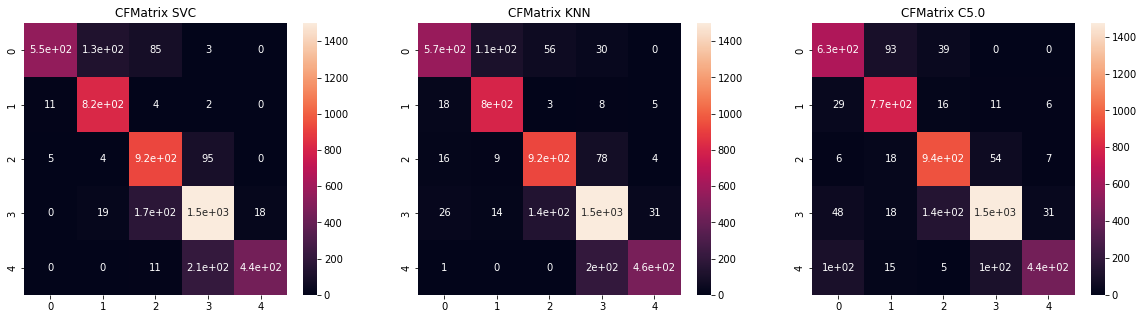

In [24]:
cf_matrix_svc = confusion_matrix(Y_train, pred_svc)
cf_matrix_knn = confusion_matrix(Y_train, pred_knn)
cf_matrix_tree = confusion_matrix(Y_train, pred_tree)

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.heatmap(cf_matrix_svc, annot=True)
plt.title("CFMatrix SVC")

plt.subplot(1, 3, 2)
sns.heatmap(cf_matrix_knn, annot=True)
plt.title("CFMatrix KNN")

plt.subplot(1, 3, 3)
sns.heatmap(cf_matrix_tree, annot=True)
plt.title("CFMatrix C5.0")

Predicting the unseen data with the model that obtained the best results.

In [25]:
np.savetxt("predicted_tree.csv", clf_c5.predict(X_test), fmt='%i', delimiter=' ')
np.savetxt("predict_knn.csv", clf_knn.predict(X_test), fmt='%i', delimiter=' ')
np.savetxt("predict_svc.csv", clf_svc.predict(X_test), fmt='%i', delimiter=' ')

In [26]:
np.unique(clf_c5.predict(X_test))

array([0, 1, 2, 3, 4])

Conclusion
add Codeadd Markdown
Regarding the metrics, we can see the best model for this specific dataset with 5000 training datasets and 10-folds cross-validation is the C5.0 Decision tree.

We can see that it achieves better results in terms of accuracy, Kappa, and predicting each class (confusion matrix). For this matter, I use this model to predict the unseen data labels.